In [1]:
!pip install torch torchvision matplotlib

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


[1/30] D Loss: 0.7947, G Loss: 2.0503


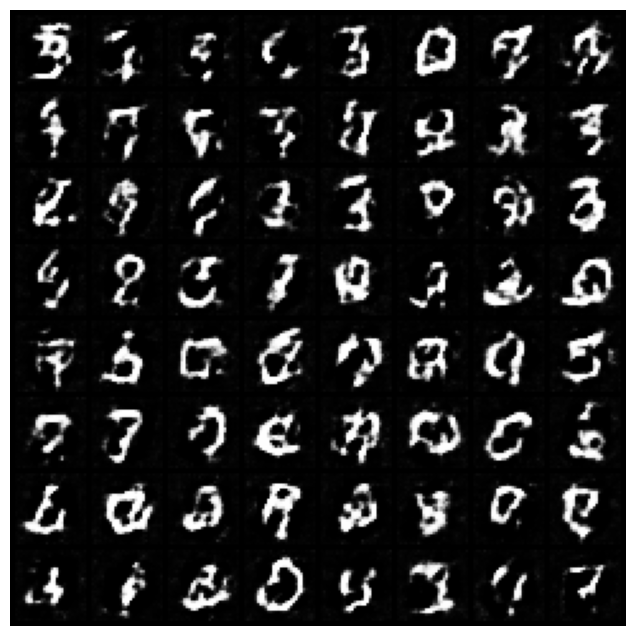

[2/30] D Loss: 0.4583, G Loss: 1.8111
[3/30] D Loss: 0.7710, G Loss: 1.7042
[4/30] D Loss: 0.5177, G Loss: 1.8403
[5/30] D Loss: 0.5220, G Loss: 1.5268


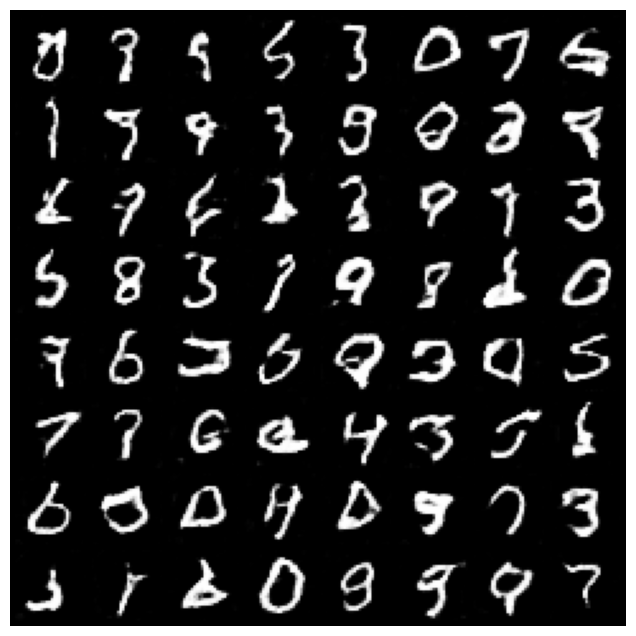

[6/30] D Loss: 0.7241, G Loss: 1.1757
[7/30] D Loss: 0.6642, G Loss: 1.2281
[8/30] D Loss: 0.6176, G Loss: 1.9078
[9/30] D Loss: 0.7730, G Loss: 1.4820
[10/30] D Loss: 0.6811, G Loss: 1.4979


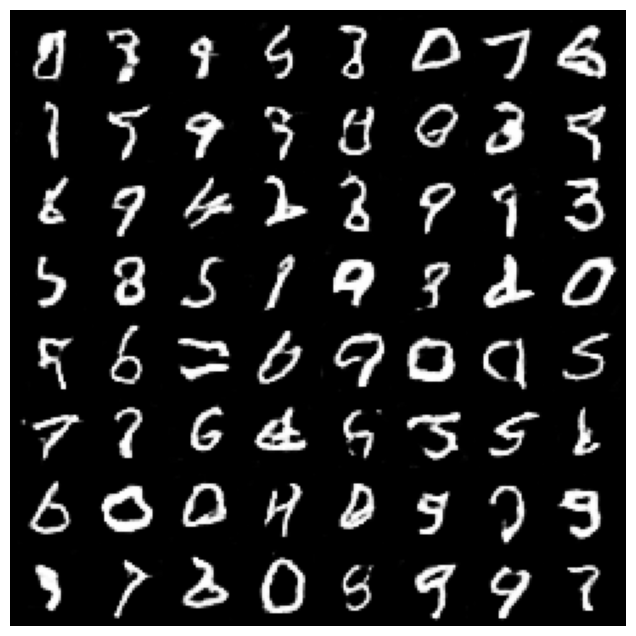

In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 하이퍼파라미터
latent_dim = 100
batch_size = 128
num_epochs = 30
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataloader = DataLoader(
    datasets.MNIST(root="./data", train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True
)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 시각화 함수
def show_generated_images(images):
    images = images.detach().cpu()
    grid = make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# 모델 초기화
G = Generator().to(device)
D = Discriminator().to(device)

# Loss & Optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# 학습 시작
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
for epoch in range(1, num_epochs + 1):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Ground truth
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # ===================== Discriminator =====================
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z)

        real_preds = D(real_imgs)
        fake_preds = D(fake_imgs.detach())

        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ===================== Generator =====================
        fake_preds = D(fake_imgs)
        g_loss = criterion(fake_preds, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"[{epoch}/{num_epochs}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # 중간 결과 확인
    if epoch % 5 == 0 or epoch == 1:
        with torch.no_grad():
            fake_imgs = G(fixed_noise)
            show_generated_images(fake_imgs)
